In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error
import dateutil
from pathlib import Path


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
status_path = Path('status.csv')
trips_path = Path('trip.csv')
weather_path = Path('weather.csv')
stations_path = Path('station.csv')

In [4]:
status_df = pd.read_csv(status_path, parse_dates=['time'])
# trips_df = pd.read_csv(trips_path)
# weather_df = pd.read_csv(weather_path)
stations_df = pd.read_csv(stations_path)

In [4]:
status_df

,station_id,bikes_available,docks_available,time
0,2,2,25,2013-08-29 12:06:01
1,2,2,25,2013-08-29 12:07:01
2,2,2,25,2013-08-29 12:08:01
3,2,2,25,2013-08-29 12:09:01
4,2,2,25,2013-08-29 12:10:01
...,...,...,...,...
71984429,84,8,7,2015-08-31 23:55:02
71984430,84,8,7,2015-08-31 23:56:01
71984431,84,8,7,2015-08-31 23:57:02
71984432,84,8,7,2015-08-31 23:58:02


In [5]:
stations_df

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013
...,...,...,...,...,...,...,...
65,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,8/25/2013
66,80,Santa Clara County Civic Center,37.352601,-121.905733,15,San Jose,12/31/2013
67,82,Broadway St at Battery St,37.798541,-122.400862,15,San Francisco,1/22/2014
68,83,Mezes Park,37.491269,-122.236234,15,Redwood City,2/20/2014


# 1) Calcolo delle oscillazioni tra "current_total" e "dock_count"

### Aggiungo la colonna "current_total" (bikes_available + docks_available) e la colonna "dock_count"

In [5]:
status_df['current_total'] = status_df['bikes_available'] + status_df['docks_available']
dropped_stations_df = stations_df.drop(["name" ,"lat", "long", "city", "installation_date"], axis=1 )
dropped_stations_df = dropped_stations_df.rename(columns={'id': 'station_id'})
complete_status_df = pd.merge(status_df, dropped_stations_df, on='station_id', how='outer')
complete_status_df

,station_id,bikes_available,docks_available,time,current_total,dock_count
0,2,2,25,2013-08-29 12:06:01,27,27
1,2,2,25,2013-08-29 12:07:01,27,27
2,2,2,25,2013-08-29 12:08:01,27,27
3,2,2,25,2013-08-29 12:09:01,27,27
4,2,2,25,2013-08-29 12:10:01,27,27
...,...,...,...,...,...,...
71984429,84,8,7,2015-08-31 23:55:02,15,15
71984430,84,8,7,2015-08-31 23:56:01,15,15
71984431,84,8,7,2015-08-31 23:57:02,15,15
71984432,84,8,7,2015-08-31 23:58:02,15,15


### Aggiungo la colonna "oscillation"

In [6]:
complete_status_df['oscillation'] = complete_status_df['current_total'] - complete_status_df['dock_count']

In [20]:
print(f'Min total oscillation: {complete_status_df["oscillation"].min()}')
print(f'Max total oscillation: {complete_status_df["oscillation"].max()}')

Min total oscillation: -23
Max total oscillation: 2


##### Questo indica che nei casi estremi per tutte le stazioni abbiamo 23 posti in meno e 2 in più nella somma di bici disponibili e posti liberi rispetto al totale di posti indicato dal file station.csv

### Raggruppo per id della stazione e calcolo la massima e la minima oscillazione per ogni stazione

In [6]:
oscillation_per_station = complete_status_df.groupby(['station_id'], sort=True).agg(
    {'oscillation': [("min_oscillation", np.min),
                     ("max_oscillation", np.max)]})

#Resetto il livello delle colonne dopo l'aggregazione
oscillation_per_station.columns = oscillation_per_station.columns.droplevel(0)
oscillation_per_station = oscillation_per_station.reset_index()

oscillation_per_station

,station_id,min_oscillation,max_oscillation
0,2,-4,0
1,3,-6,0
2,4,-3,0
3,5,-1,0
4,6,-2,0
...,...,...,...
65,77,-9,0
66,80,-2,0
67,82,-10,0
68,83,-3,0


70


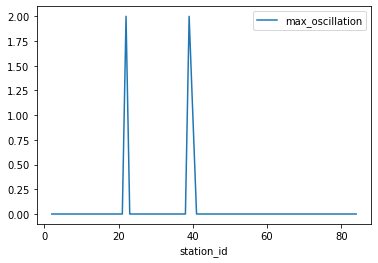

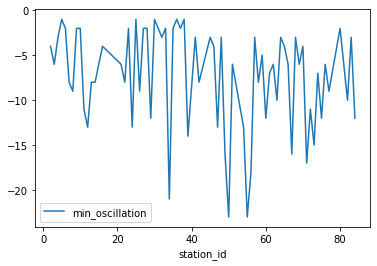

In [9]:
print(oscillation_per_station['station_id'].size)
oscillation_per_station.plot(x="station_id", y="max_oscillation")
oscillation_per_station.plot(x="station_id", y="min_oscillation")

### Raggruppo per id della stazione e calcolo il MSE tra dock_count e current_total

,station_id,MSE_oscillation
0,2,0.076953
1,3,0.011264
2,4,0.031308
3,5,0.016520
4,6,0.007668
...,...,...
65,77,3.282540
66,80,0.014057
67,82,0.035298
68,83,0.005982


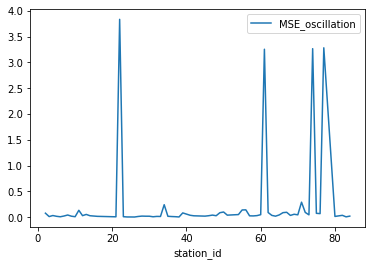

In [7]:
def mse(group):
    d={}
    d["MSE_oscillation"]=mean_squared_error(group["dock_count"], group["current_total"])
    return pd.Series(d)

MSE_per_station_df = complete_status_df.groupby(['station_id'], sort=True).apply(mse)

#Resetto il livello delle colonne dopo l'aggregazione
MSE_per_station_df = MSE_per_station_df.reset_index()

MSE_per_station_df.plot(x="station_id", y="MSE_oscillation")
MSE_per_station_df

#### Ordino per "MSE_oscillation" decrescente

In [8]:
MSE_per_station_df = MSE_per_station_df.sort_values(by=["MSE_oscillation"], ascending=False)
MSE_per_station_df

,station_id,MSE_oscillation
15,22,3.834335
65,77,3.282540
62,74,3.265925
49,61,3.254769
59,71,0.290300
...,...,...
68,83,0.005982
31,38,0.003887
17,24,0.003795
18,25,0.003490


#### Valuto il numero di situazioni per le stazioni con picchi di MSE in cui l'oscillazione è >5

In [8]:
# mask = complete_status_df['station_id'].isin({22,77,74,61}) & np.abs(complete_status_df['oscillation'])>2
oscillation_mask = np.abs(complete_status_df['oscillation'])>5
stations_mask = complete_status_df['station_id'].isin({22,77,74,61})

            count
station_id       
22              1
61            242
74            420
77             10
            total_count
station_id             
22              1047141
61              1047141
74              1047140
77              1047139
            count  total_count        %count
station_id                                  
22              1      1047141  9.549812e-07
61            242      1047141  2.311055e-04
74            420      1047140  4.010925e-04
77             10      1047139  9.549831e-06


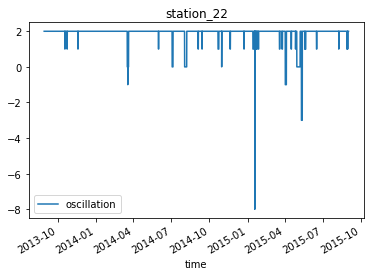

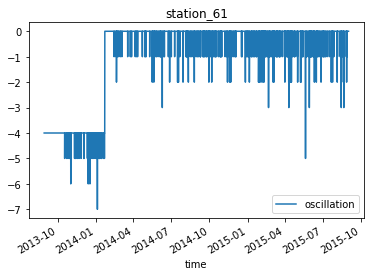

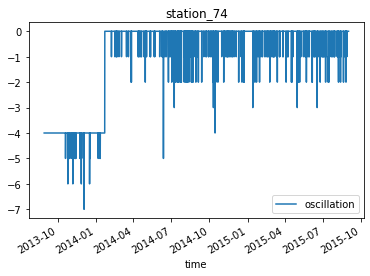

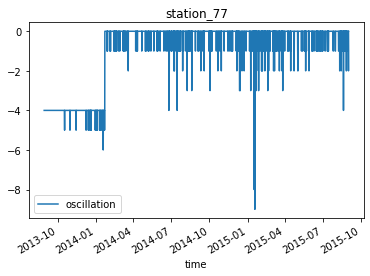

In [9]:
filtered_df= complete_status_df[oscillation_mask & stations_mask]
filtered2_df = complete_status_df[stations_mask]


for i in (22,61,74,77):
    complete_status_df[complete_status_df['station_id'] == i].plot(x='time', y='oscillation', title= "station_{}".format(i))


count_oscillation_df = filtered_df.groupby(['station_id']).agg(
    {"station_id": [('count','count')]})

totalcount_df = filtered2_df.groupby(['station_id']).agg(
    {"station_id": [('total_count','count')]})



#Resetto il livello delle colonne dopo l'aggregazione
count_oscillation_df.columns = count_oscillation_df.columns.droplevel(0)
totalcount_df.columns = totalcount_df.columns.droplevel(0)


merge_counts_df = pd.merge(count_oscillation_df, totalcount_df, on='station_id', how='outer')

merge_counts_df['%count'] = merge_counts_df['count']/merge_counts_df['total_count']
print(count_oscillation_df.to_string())
print(totalcount_df.to_string())
print(merge_counts_df.to_string())


### Ottengo e salvo un dataframe contenente "station_id", "time" ed "oscillation" per tutte le situazioni in cui |oscillation| > 5

In [10]:
filtered_all_station = complete_status_df[oscillation_mask]
filtered_all_station = filtered_all_station.drop(["docks_available" ,"bikes_available", "current_total", "dock_count"], axis=1 )
all_station_oscillation_df = filtered_all_station.sort_values(['station_id','time'])

print("number of distinct station with an oscillation >5: {}".format(all_station_oscillation_df['station_id'].unique().size))

all_station_oscillation_df.to_csv("all_station_oscillation.csv", index=False )
all_station_oscillation_df

number of distinct station with an oscillation >5: 39


,station_id,time,oscillation
1771793,3,2015-01-19 17:31:02,-6
1771794,3,2015-01-19 17:32:03,-6
1771795,3,2015-01-19 17:33:02,-6
1771796,3,2015-01-19 17:34:02,-6
1771797,3,2015-01-19 17:35:02,-6
...,...,...,...
71662241,84,2015-01-19 17:56:03,-8
71662242,84,2015-01-19 17:57:02,-8
71662243,84,2015-01-19 17:58:03,-8
71662244,84,2015-01-19 17:59:02,-8


# 2) Valutazione della regolarità con cui sono stati raccolti i dati

#### Partendo dalla tabella status_df, per ogni stazione ricavo il primo timestamp, l'ultimo timestamp e il numero di rilievi in quella finestra di tempo, in modo tale da ottenere una stima approssimativa della regolarità con cui si sono ottenuti i dati

In [ ]:
regularity_estimation = status_df.groupby(['station_id'], sort=True).agg(
    {"time": [('start','min'), 
              ('end','max'), 
              'count']})
#Resetto il livello delle colonne dopo l'aggregazione
regularity_estimation.columns = regularity_estimation.columns.droplevel(0)
regularity_estimation = regularity_estimation.reset_index()
print(regularity_estimation.to_string())

In [13]:

regularity_estimation[['start','end']] = regularity_estimation[['start','end']].apply(pd.to_datetime) #converto le colonne in datetime
regularity_estimation['difference_in_minutes'] = (regularity_estimation['end'] - regularity_estimation['start']).astype('timedelta64[m]')

# Calcolando la differenza tra il "2013-08-29 12:06:01" e il "2015-08-31 23:59:02" su internet è venuto fuori
# 1054790 contro il 1054793.0 ottenuto qui, quindi con una differenza di 3 minuti. Tuttavia credo che tale 
# differenza sia abbastanza trascurabile


# Calcolo la frequenza media di rilevamento tramite il rapporto numero totali di rilevamenti / numero totale 
# di minuti trascorsi tra il primo e l'ultimo rilevamento
regularity_estimation["frequency"] = regularity_estimation["count"] / regularity_estimation["difference_in_minutes"]


regularity_estimation


,station_id,start,end,count,difference_in_minutes,frequency
0,2,2013-08-29 12:06:01,2015-08-31 23:59:02,1046898,1054793.0,0.992515
1,3,2013-08-29 12:06:01,2015-08-31 23:59:02,1047113,1054793.0,0.992719
2,4,2013-08-29 12:06:01,2015-08-31 23:59:02,1047100,1054793.0,0.992707
3,5,2013-08-29 12:06:01,2015-08-31 23:59:02,1047142,1054793.0,0.992746
4,6,2013-08-29 12:06:01,2015-08-31 23:59:02,1047142,1054793.0,0.992746
...,...,...,...,...,...,...
65,77,2013-08-29 12:06:01,2015-08-31 23:59:02,1047139,1054793.0,0.992744
66,80,2013-12-31 10:29:03,2015-08-31 23:59:02,872134,876329.0,0.995213
67,82,2014-01-22 05:21:02,2015-08-31 23:59:02,840950,844958.0,0.995257
68,83,2014-02-20 12:24:02,2015-08-31 23:59:02,798868,802775.0,0.995133


Osservando "frequency" (count/difference_in_minutes) possiamo affermare che la frequenza media dei rilevamenti sia di circa un minuto per tutte le stazioni.

Il rapporto non è 1 in quanto, dando un'occhiata veloce al dataset, effettivamente sembra che sia saltata qualche lettura con un salto quindi di 2 minuti tra due letture successive.

#### Per avere una visione globale plotto di seguito tale frequenza di rilevamento per tutte le stazioni.

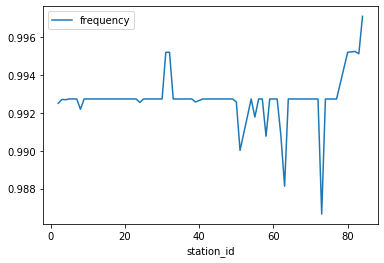

In [14]:
regularity_estimation.plot(x="station_id", y="frequency")

Anche dal plot possiamo notare che la frequenza media di tutte le stazioni si aggira intorno al 0.99. In ultima analisi possiamo quindi affermare che in media la frequenza di rilevamento sia di 1 minuto per tutte le stazioni.

# 3) Filtraggio 

### Filtro le letture con un'oscillazione in valore assoluto > 5

In [11]:
oscillation_mask = np.abs(complete_status_df['oscillation'])>5
filtered_complete_status_df = complete_status_df.drop(complete_status_df[oscillation_mask].index)
filtered_complete_status_df

,station_id,bikes_available,docks_available,time,current_total,dock_count,oscillation
0,2,2,25,2013-08-29 12:06:01,27,27,0
1,2,2,25,2013-08-29 12:07:01,27,27,0
2,2,2,25,2013-08-29 12:08:01,27,27,0
3,2,2,25,2013-08-29 12:09:01,27,27,0
4,2,2,25,2013-08-29 12:10:01,27,27,0
...,...,...,...,...,...,...,...
71984429,84,8,7,2015-08-31 23:55:02,15,15,0
71984430,84,8,7,2015-08-31 23:56:01,15,15,0
71984431,84,8,7,2015-08-31 23:57:02,15,15,0
71984432,84,8,7,2015-08-31 23:58:02,15,15,0


In [12]:
filtered_dropped_status = filtered_complete_status_df.drop(["current_total", "dock_count", "oscillation"], axis=1)
filtered_dropped_status

,station_id,bikes_available,docks_available,time
0,2,2,25,2013-08-29 12:06:01
1,2,2,25,2013-08-29 12:07:01
2,2,2,25,2013-08-29 12:08:01
3,2,2,25,2013-08-29 12:09:01
4,2,2,25,2013-08-29 12:10:01
...,...,...,...,...
71984429,84,8,7,2015-08-31 23:55:02
71984430,84,8,7,2015-08-31 23:56:01
71984431,84,8,7,2015-08-31 23:57:02
71984432,84,8,7,2015-08-31 23:58:02


In [10]:
filtered_dropped_status.to_csv("filtered_status.csv", index=False )

# 4) Finestramento

#### A quanto pare utilizzando le API di pandas per il finestamento, non è possibile settare uno step delle finestre maggiore di uno, quindi utilizzerò il groupby e l'ausilio della classe Grouper di pandas, la quale campiona con intervalli fissi di 10 min (parametro passato da me) e poi considera tutte le entry con un timestamp compreso in quella finestra. In questo modo però le finestre risultanti non sono sovrapponibili.

#### Partendo dal dataframe "complete_status_df" effettuo il finestramento desiderato. L'obiettivo è quello di ottenere una tabella contenente i seguenti attributi:
    + max, min e numero medio del numero di bici disponibili
    + max e min  e numero medio del numero di slot liberi
    + se c’e’ almeno una riga in cui la stazione e’ stata piena
    + se c’e’ almeno una riga in cui la stazione e’ vuota
    + rapporto: numero di righe stazione piena / numero di righe totali nella finestra
    + rapporto: numero di righe stazione vuota / numero di righe totali nella finestra
    + il primo timestamp all’inizio della finestra
    + quante righe ci sono (quindi se < 10 la frequenza di campionamento e’ irregolare, informazione che abbiamo verificato in media nel punto precedente, ma vale la pena comunque controllare per singola finestra)


In [16]:
# setto la dimensione della finestra 
param=10
width = "{}min".format(param)

window= filtered_complete_status_df.groupby(["station_id", pd.Grouper(key='time', freq=width)])

final_df = window.agg(
    {"time": [('first_timestamp','min'),
             ("#window_entries", lambda x: len(x))],
     
     "bikes_available": [('min_bikes_available','min'),
                         ('max_bikes_available','max'),
                         ('mean_bikes_available','mean'),
                         ('station_full', lambda x: 1 if (x==0).sum()>0 else 0),
                         ('%station_full', lambda x: (x==0).sum()/len(x))
                        ],
     "docks_available": [('min_docks_available','min'),
                         ('max_docks_available','max'),
                         ('mean_docks_available','mean'),
                         ('station_empty', lambda x: 1 if (x==0).sum()>0 else 0),
                         ('%station_empty', lambda x: (x==0).sum()/len(x))
                        ],
    })

final_df

time                  \
                                   first_timestamp #window_entries   
station_id time                                                      
2          2013-08-29 12:00:00 2013-08-29 12:06:01               4   
           2013-08-29 12:10:00 2013-08-29 12:10:01               8   
           2013-08-29 12:20:00 2013-08-29 12:20:01               8   
           2013-08-29 12:30:00 2013-08-29 12:30:01               9   
           2013-08-29 12:40:00 2013-08-29 12:40:02              10   
...                                            ...             ...   
84         2015-08-31 23:10:00 2015-08-31 23:10:02              10   
           2015-08-31 23:20:00 2015-08-31 23:20:02              10   
           2015-08-31 23:30:00 2015-08-31 23:30:02              10   
           2015-08-31 23:40:00 2015-08-31 23:40:02              10   
           2015-08-31 23:50:00 2015-08-31 23:50:02              10   

                                   bikes_available                      \
                               min_bikes_available max_bikes_available   
station_id time                                                          
2          2013-08-29 12:00:00                   2                   2   
           2013-08-29 12:10:00                   2                   2   
           2013-08-29 12:20:00                   2                   2   
           2013-08-29 12:30:00                   2                   2   
           2013-08-29 12:40:00                   2                   2   
...                                            ...                 ...   
84         2015-08-31 23:10:00                   8                   8   
           2015-08-31 23:20:00                   8                   8   
           2015-08-31 23:30:00                   8                   8   
           2015-08-31 23:40:00                   8                   8   
           2015-08-31 23:50:00                   8                   8   

                                                                  \
                               mean_bikes_available station_full   
station_id time                                                    
2          2013-08-29 12:00:00                  2.0            0   
           2013-08-29 12:10:00                  2.0            0   
           2013-08-29 12:20:00                  2.0            0   
           2013-08-29 12:30:00                  2.0            0   
           2013-08-29 12:40:00                  2.0            0   
...                                             ...          ...   
84         2015-08-31 23:10:00                  8.0            0   
           2015-08-31 23:20:00                  8.0            0   
           2015-08-31 23:30:00                  8.0            0   
           2015-08-31 23:40:00                  8.0            0   
           2015-08-31 23:50:00                  8.0            0   

                                                 docks_available  \
                               %station_full min_docks_available   
station_id time                                                    
2          2013-08-29 12:00:00           0.0                  25   
           2013-08-29 12:10:00           0.0                  25   
           2013-08-29 12:20:00           0.0                  25   
           2013-08-29 12:30:00           0.0                  25   
           2013-08-29 12:40:00           0.0                  25   
...                                      ...                 ...   
84         2015-08-31 23:10:00           0.0                   7   
           2015-08-31 23:20:00           0.0                   7   
           2015-08-31 23:30:00           0.0                   7   
           2015-08-31 23:40:00           0.0                   7   
           2015-08-31 23:50:00           0.0                   7   

                                                                         \
                               max_docks_availa

In [17]:
complete_df = final_df.copy(deep=True)
complete_df

time                  \
                                   first_timestamp #window_entries   
station_id time                                                      
2          2013-08-29 12:00:00 2013-08-29 12:06:01               4   
           2013-08-29 12:10:00 2013-08-29 12:10:01               8   
           2013-08-29 12:20:00 2013-08-29 12:20:01               8   
           2013-08-29 12:30:00 2013-08-29 12:30:01               9   
           2013-08-29 12:40:00 2013-08-29 12:40:02              10   
...                                            ...             ...   
84         2015-08-31 23:10:00 2015-08-31 23:10:02              10   
           2015-08-31 23:20:00 2015-08-31 23:20:02              10   
           2015-08-31 23:30:00 2015-08-31 23:30:02              10   
           2015-08-31 23:40:00 2015-08-31 23:40:02              10   
           2015-08-31 23:50:00 2015-08-31 23:50:02              10   

                                   bikes_available                      \
                               min_bikes_available max_bikes_available   
station_id time                                                          
2          2013-08-29 12:00:00                   2                   2   
           2013-08-29 12:10:00                   2                   2   
           2013-08-29 12:20:00                   2                   2   
           2013-08-29 12:30:00                   2                   2   
           2013-08-29 12:40:00                   2                   2   
...                                            ...                 ...   
84         2015-08-31 23:10:00                   8                   8   
           2015-08-31 23:20:00                   8                   8   
           2015-08-31 23:30:00                   8                   8   
           2015-08-31 23:40:00                   8                   8   
           2015-08-31 23:50:00                   8                   8   

                                                                  \
                               mean_bikes_available station_full   
station_id time                                                    
2          2013-08-29 12:00:00                  2.0            0   
           2013-08-29 12:10:00                  2.0            0   
           2013-08-29 12:20:00                  2.0            0   
           2013-08-29 12:30:00                  2.0            0   
           2013-08-29 12:40:00                  2.0            0   
...                                             ...          ...   
84         2015-08-31 23:10:00                  8.0            0   
           2015-08-31 23:20:00                  8.0            0   
           2015-08-31 23:30:00                  8.0            0   
           2015-08-31 23:40:00                  8.0            0   
           2015-08-31 23:50:00                  8.0            0   

                                                 docks_available  \
                               %station_full min_docks_available   
station_id time                                                    
2          2013-08-29 12:00:00           0.0                  25   
           2013-08-29 12:10:00           0.0                  25   
           2013-08-29 12:20:00           0.0                  25   
           2013-08-29 12:30:00           0.0                  25   
           2013-08-29 12:40:00           0.0                  25   
...                                      ...                 ...   
84         2015-08-31 23:10:00           0.0                   7   
           2015-08-31 23:20:00           0.0                   7   
           2015-08-31 23:30:00           0.0                   7   
           2015-08-31 23:40:00           0.0                   7   
           2015-08-31 23:50:00           0.0                   7   

                                                                         \
                               max_docks_availa

In [19]:
complete_df.columns = complete_df.columns.droplevel(0)
complete_df = complete_df.reset_index()
complete_df.to_csv("filtered_final.csv", index=False )
complete_df

,station_id,time,first_timestamp,#window_entries,min_bikes_available,max_bikes_available,mean_bikes_available,station_full,%station_full,min_docks_available,max_docks_available,mean_docks_available,station_empty,%station_empty
0,2,2013-08-29 12:00:00,2013-08-29 12:06:01,4,2,2,2.0,0,0.0,25,25,25.0,0,0.0
1,2,2013-08-29 12:10:00,2013-08-29 12:10:01,8,2,2,2.0,0,0.0,25,25,25.0,0,0.0
2,2,2013-08-29 12:20:00,2013-08-29 12:20:01,8,2,2,2.0,0,0.0,25,25,25.0,0,0.0
3,2,2013-08-29 12:30:00,2013-08-29 12:30:01,9,2,2,2.0,0,0.0,25,25,25.0,0,0.0
4,2,2013-08-29 12:40:00,2013-08-29 12:40:02,10,2,2,2.0,0,0.0,25,25,25.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7223892,84,2015-08-31 23:10:00,2015-08-31 23:10:02,10,8,8,8.0,0,0.0,7,7,7.0,0,0.0
7223893,84,2015-08-31 23:20:00,2015-08-31 23:20:02,10,8,8,8.0,0,0.0,7,7,7.0,0,0.0
7223894,84,2015-08-31 23:30:00,2015-08-31 23:30:02,10,8,8,8.0,0,0.0,7,7,7.0,0,0.0
7223895,84,2015-08-31 23:40:00,2015-08-31 23:40:02,10,8,8,8.0,0,0.0,7,7,7.0,0,0.0


# 5) Calcolo statistiche sulle situazioni critiche

### Calcolo le statistiche separatamente per ogni singola stazione 

Creare un dataframe con le seguenti statistiche:

    + numero di volte in cui le stazioni sono completamente piene
    + numero di volte in cui le stazioni sono completamente vuote
    + percentuale di volte in cui le stazioni sono completamente piene rispetto al numero totale di letture per quella stazione
    + percentuale di volte in cui le stazioni sono completamente vuote rispetto al numero totale di letture per quella stazione
    + percentuale di criticità totali: numero di situazioni in cui le stazioni sono piene + numero di situazioni in cui le stazioni sono vuote / numero totale di letture del fataframe.
    + numero di volte in cui il la quantità "bikes_available" è uguale a 1 e quante volte è uguale a 2
    + numero di volte in cui il la quantità "docks_available" è uguale a 1 e quante volte è uguale a 2

In [43]:
total_critical_situation = ((filtered_complete_status_df.bikes_available==0).sum() + 
                            (filtered_complete_status_df.docks_available==0).sum())/ len(filtered_complete_status_df)
print(f'total_critical_situation: {total_critical_situation}')

critical_situations = filtered_complete_status_df.groupby(['station_id'], sort=True).agg(
    {"bikes_available": [('full',lambda x: (x==0).sum()),
                         ('%full',lambda x: ((x==0).sum())/len(x)),
                         ('1_bike_available',lambda x: (x==1).sum()),
                         ('2_bikes_available',lambda x: (x==2).sum())
                         ],
              
    "docks_available": [('empty',lambda x: (x==0).sum()),
                         ('%empty',lambda x: ((x==0).sum())/len(x)),
                         ('1_dock_available',lambda x: (x==1).sum()),
                         ('2_docks_available',lambda x: (x==2).sum()),
                         ('%total_critical_situation', lambda x: total_critical_situation)
                        ],
     })
              
critical_situations

total_critical_situation: 0.011861458605841708


bikes_available                                               \
                      full     %full 1_bike_available 2_bikes_available   
station_id                                                                
2                     1340  0.001280             1793              4608   
3                     1056  0.001008             1205              3510   
4                    10618  0.010140            29688             57923   
5                     1321  0.001262             6934             12093   
6                     3564  0.003404            15438             14245   
...                    ...       ...              ...               ...   
77                    4432  0.004233             7461             12674   
80                    2105  0.002414            19885             21070   
82                   17808  0.021178            31032             41572   
83                     808  0.001011             7424             19814   
84                    3630  0.004962             7018             21101   

           docks_available                                               \
                     empty    %empty 1_dock_available 2_docks_available   
station_id                                                                
2                      466  0.000445             1516              2309   
3                     4817  0.004600            13223             34812   
4                     6614  0.006316            12838             37107   
5                        0  0.000000                0               112   
6                     3633  0.003469            13852             24770   
...                    ...       ...              ...               ...   
77                    3129  0.002988             7272              9514   
80                       5  0.000006               10              1847   
82                    3738  0.004445             5534             12167   
83                       0  0.000000                0                 0   
84                    1744  0.002384             2743             12790   

                                      
           %total_critical_situation  
station_id                            
2                           0.011861  
3                           0.011861  
4                           0.011861  
5                           0.011861  
6                           0.011861  
...                              ...  
77                          0.011861  
80                          0.011861  
82                          0.011861  
83                          0.011861  
84                          0.011861  

[70 rows x 9 columns]

In [44]:
critical_situations.columns = critical_situations.columns.droplevel(0)
critical_situations = critical_situations.reset_index()
critical_situations

,station_id,full,%full,1_bike_available,2_bikes_available,empty,%empty,1_dock_available,2_docks_available,%total_critical_situation
0,2,1340,0.001280,1793,4608,466,0.000445,1516,2309,0.011861
1,3,1056,0.001008,1205,3510,4817,0.004600,13223,34812,0.011861
2,4,10618,0.010140,29688,57923,6614,0.006316,12838,37107,0.011861
3,5,1321,0.001262,6934,12093,0,0.000000,0,112,0.011861
4,6,3564,0.003404,15438,14245,3633,0.003469,13852,24770,0.011861
...,...,...,...,...,...,...,...,...,...,...
65,77,4432,0.004233,7461,12674,3129,0.002988,7272,9514,0.011861
66,80,2105,0.002414,19885,21070,5,0.000006,10,1847,0.011861
67,82,17808,0.021178,31032,41572,3738,0.004445,5534,12167,0.011861
68,83,808,0.001011,7424,19814,0,0.000000,0,0,0.011861


In [45]:
critical_situations.to_csv('critical_situations.csv',index=False)

### Calcolo le statistiche per tutto l'intero dataset

In [2]:
data_path = Path('filtered_status.csv')
cleaned_df = pd.read_csv(data_path)

In [3]:
filter_empty_situation_df = cleaned_df.drop(cleaned_df[cleaned_df["bikes_available"]==0].index)
filter_full_situation_df = cleaned_df.drop(cleaned_df[cleaned_df["docks_available"]==0].index)
# print(len(cleaned_df))
# print(len(filter_empty_situation_df))

Numero di record totali: 71977910

Numero di criticità con stazione Piena: 326118
Percentuale di criticità con stazione Piena: 0.45%

Numero di criticità con stazione Vuota: 527645
Percentuale di criticità con stazione Vuota: 0.73%

Numero di criticità con stazione Quasi Piena: 2027537
Percentuale di criticità con stazione Quasi Piena: 2.82%

Numero di criticità con stazione Quasi Vuota: 2783260
Percentuale di criticità con stazione Quasi Vuota: 3.87%

Numero di criticità con stazione Quasi Piena o Piena: 2353655
Percentuale di criticità con stazione Quasi Piena o Piena: 3.27%

Numero di criticità con stazione Quasi Vuota o Vuota: 3310905
Percentuale di criticità con stazione Quasi Vuota o Vuota: 4.60%

Numero di criticità con stazione Vuota o Piena: 853763
Percentuale di criticità con stazione Vuota o Piena: 1.19%

Numero di criticità totali: 5664560
Percentuale di criticità totali: 7.87%



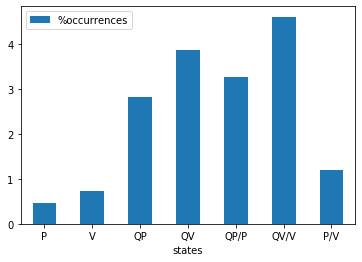

In [10]:

print(f'Numero di record totali: {len(cleaned_df)}\n')

full_situation = (cleaned_df.docks_available==0).sum()/ len(cleaned_df)
print(f'Numero di criticità con stazione Piena: {(cleaned_df.docks_available==0).sum()}')
print(f'Percentuale di criticità con stazione Piena: {full_situation*100:.2f}%\n')

empty_situation = (cleaned_df.bikes_available==0).sum()/ len(cleaned_df)
print(f'Numero di criticità con stazione Vuota: {(cleaned_df.bikes_available==0).sum()}')
print(f'Percentuale di criticità con stazione Vuota: {empty_situation*100:.2f}%\n')

almost_full_situation = (filter_full_situation_df.docks_available<=2).sum()/ len(cleaned_df)
print(f'Numero di criticità con stazione Quasi Piena: {(filter_full_situation_df.docks_available<=2).sum()}')
print(f'Percentuale di criticità con stazione Quasi Piena: {almost_full_situation*100:.2f}%\n')

almost_empty_situation = (filter_empty_situation_df.bikes_available<=2).sum()/ len(cleaned_df)
print(f'Numero di criticità con stazione Quasi Vuota: {(filter_empty_situation_df.bikes_available<=2).sum()}')
print(f'Percentuale di criticità con stazione Quasi Vuota: {almost_empty_situation*100:.2f}%\n')

full_almost_full_situation = (cleaned_df.docks_available<=2).sum()/ len(cleaned_df)
print(f'Numero di criticità con stazione Quasi Piena o Piena: {(cleaned_df.docks_available<=2).sum()}')
print(f'Percentuale di criticità con stazione Quasi Piena o Piena: {full_almost_full_situation*100:.2f}%\n')

empty_almost_empty_situation = (cleaned_df.bikes_available<=2).sum()/ len(cleaned_df)
print(f'Numero di criticità con stazione Quasi Vuota o Vuota: {(cleaned_df.bikes_available<=2).sum()}')
print(f'Percentuale di criticità con stazione Quasi Vuota o Vuota: {empty_almost_empty_situation*100:.2f}%\n')

full_empty_situation = ((cleaned_df.bikes_available==0).sum() + 
                            (cleaned_df.docks_available==0).sum())/ len(cleaned_df)
print(f'Numero di criticità con stazione Vuota o Piena: {(cleaned_df.bikes_available==0).sum() + (cleaned_df.docks_available==0).sum()}')
print(f'Percentuale di criticità con stazione Vuota o Piena: {full_empty_situation*100:.2f}%\n')

all_critical_situation = ((cleaned_df.bikes_available<=2).sum() 
                          + (cleaned_df.docks_available<=2).sum() )/ len(cleaned_df)
print(f'Numero di criticità totali: {(cleaned_df.bikes_available<=2).sum() + (cleaned_df.docks_available<=2).sum()}')
print(f'Percentuale di criticità totali: {all_critical_situation*100:.2f}%\n')


df = pd.DataFrame({'states':['P', 'V', 'QP', 'QV', 'QP/P', 'QV/V', 'P/V'], 
                   '%occurrences':[full_situation*100,
                        empty_situation*100,
                        almost_full_situation*100,
                        almost_empty_situation*100,
                        full_almost_full_situation*100,
                        empty_almost_empty_situation*100,
                        full_empty_situation*100]})
ax = df.plot.bar(x='states', y='%occurrences', rot=0)